## Movie Sales Time Series Project

In [39]:
library(ggplot2)
install.packages("gridExtra")               
library(gridExtra) 
#install.packages("forecast", repo = 'https://mac.R-project.org')
library(forecast)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [40]:
chicago <- read.delim("chicago.txt", header=FALSE)
time = 1:106
data = data.frame(time, chicago[,1])
colnames(data) = c("time", "sales")
#The first 2 columns of the dataframe
chicago[1:4,]

V1,V2
4944,1/3/2003
6957,1/4/2003
4472,1/5/2003
1691,1/6/2003


In [41]:
x = ggplot(data = data, mapping = aes(x = data$time, y = data$sales))+
           geom_line(col = 'dark blue')+
           labs(x = 'time', y = 'sales')

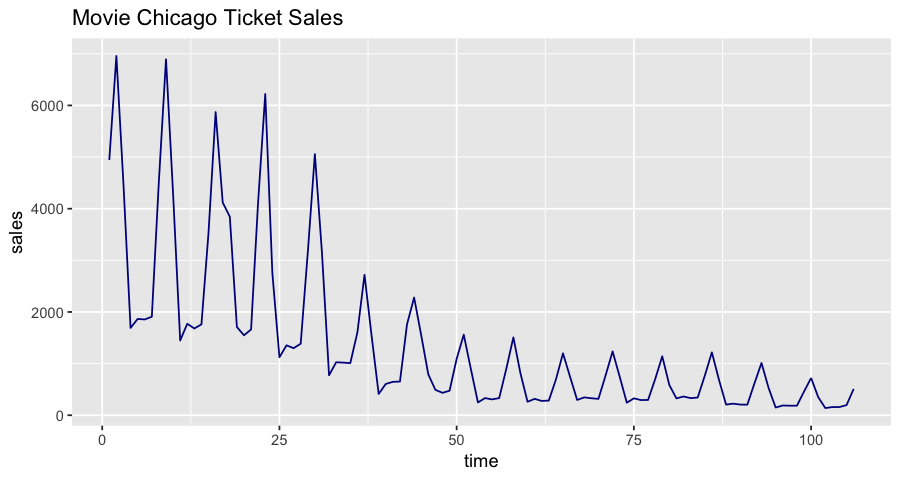

In [49]:
options(repr.plot.width = 7.5, repr.plot.height = 4)
x + ggtitle(sprintf(
    "Movie Chicago Ticket Sales", 
    getOption("repr.plot.width"),
    getOption("repr.plot.height")
))

### Visualizing Data

First I will show a plot of the data so I can make initial speculations. This rudimentary step is necessary for understanding the data and providing initial direction for where our analysis will take us. 

It can clearly be seen that there is a downward trend in the data. As time goes on more people have already seen the movie which leads to less tickets being sold. There is also a seasonal effect that is seen by the sharp spikes in the data. The peak represents the day Saturday. The weekends have high movie attendance, and Monday thorugh Thursday have low movie attedance rates. 

Below I will be adding a few variables to the dataframe. First, I will create a variable that assigns a day of the week to the data. This will treat day of the week as a factor variable allowing me to take seasonality effect into account. Next, I will be applying transformations to the sales data. The transformations will be explained later. 

In [43]:
### I will be adding some new variables to the dataframe
#Adding a variable for each day of the week
days = c(rep(c("F", "Sa", "Su", "M", "Tu", "W", "Th"), times = 15), "F")
data = cbind(data, days)
#Creating variable TicketSales that is not included in dataframe
TicketSales = data$sales

#Here I apply transformations to the data and add them to the dataframe
LogSales = log(TicketSales)
data = cbind(data, LogSales)

SquareSales = (TicketSales)^(1/2)
data = cbind(data, SquareSales)

CubeSales = (TicketSales)^(1/3)
data = cbind(data, CubeSales)

LogInverseSales = 1/log(TicketSales)
data = cbind(data, LogInverseSales)

SquareInverseSales = (TicketSales)^(-1/2)
data = cbind(data, SquareInverseSales)

data[1:3,]

time,sales,days,LogSales,SquareSales,CubeSales,LogInverseSales,SquareInverseSales
1,4944,F,8.505930,70.31358,17.03568,0.1175650,0.01422200
2,6957,Sa,8.847504,83.40863,19.09006,0.1130262,0.01198917
3,4472,Su,8.405591,66.87301,16.47532,0.1189684,0.01495372


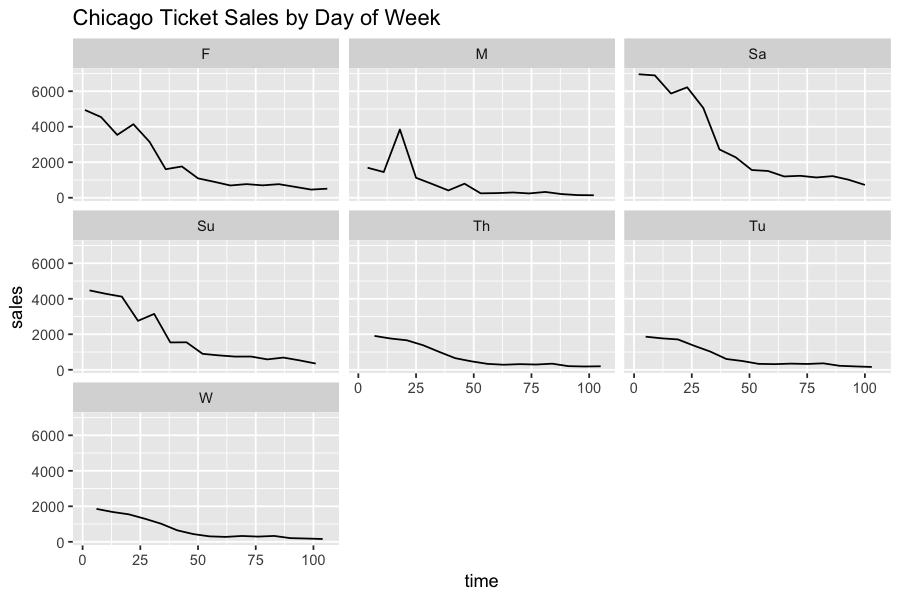

In [50]:
ByDay = ggplot(data=data, aes(x=time, y=sales)) +
            geom_line() +
            facet_wrap(~days)
options(repr.plot.width = 7.5, repr.plot.height = 5)
ByDay + ggtitle(sprintf(
    "Chicago Ticket Sales by Day of Week", 
    getOption("repr.plot.width"),
    getOption("repr.plot.height")))

Here is a visualization showing how day of the week effects the amount of sales. Monday, Tuesday, Wednesday, and Thursday all have low movie sales. The spike on Monday represents Martin Luther King Day. Saturday sees the most sales followed by Friday and Sunday. 

### Transformations

Below the 5 transfromations are shown along with the original data. The purpose of doing this is to perform time series. In order to do time series we need to generate something called the rough series which has to meet certain criteria. Below we want to find the graph that has oscillations of similar heights and that has a trend which on average isn't increasing or decreasing. The log sales seem to be close to meeting both of these requirements

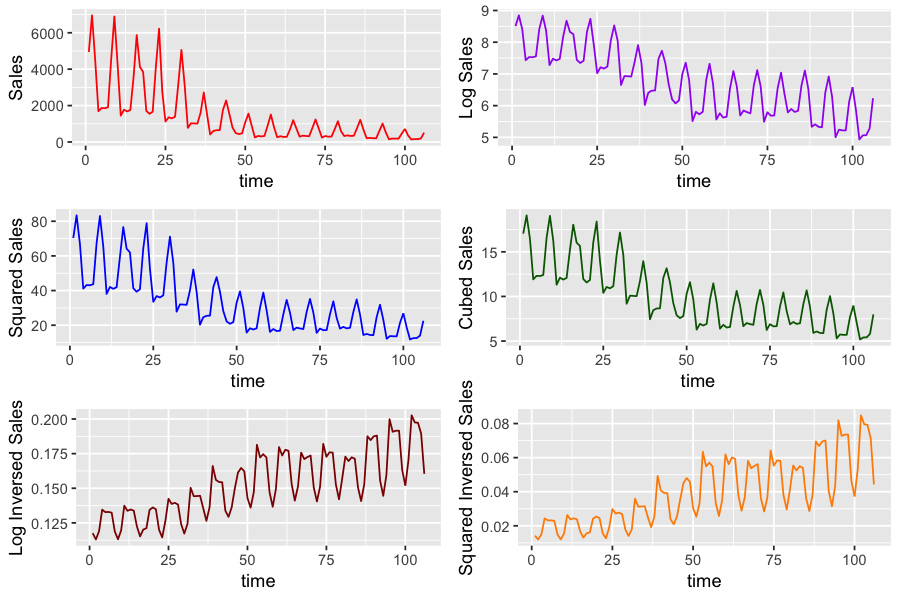

In [51]:
ggp1 = ggplot(data = data, mapping = aes(x = time, y = sales))+
           geom_line(col = 'red')+
           labs(x = 'time', y = 'Sales')
ggp2 = ggplot(data = data, mapping = aes(x = time, y = LogSales))+
           geom_line(col = 'purple')+
           labs(x = 'time', y = 'Log Sales')
ggp3 = ggplot(data = data, mapping = aes(x = time, y = SquareSales))+
           geom_line(col = 'blue')+
           labs(x = 'time', y = 'Squared Sales')
ggp4 = ggplot(data = data, mapping = aes(x = time, y = CubeSales))+
           geom_line(col = 'dark green')+
           labs(x = 'time', y = 'Cubed Sales')
ggp5 = ggplot(data = data, mapping = aes(x = time, y = LogInverseSales))+
           geom_line(col = 'dark red')+
           labs(x = 'time', y = 'Log Inversed Sales')
ggp6 = ggplot(data = data, mapping = aes(x = time, y = SquareInverseSales))+
           geom_line(col = 'dark orange')+
           labs(x = 'time', y = 'Squared Inversed Sales')


grid.arrange(ggp1, ggp2, ggp3, ggp4, ggp5, ggp6, ncol = 2) 

### Fitting the Model

Below we fit the model with a regression that will allow us to perform time series analysis. Our goal is to use the 'rough part' of our time series to create a more accurate model. The 'rough part' will be explained later. Our regression consists of 7 dummy variables for each day of the week, and 2 trend components of which one is nonlinear. The nonlinearity is why we will use the LogSales and why we include the (time^2) component. 

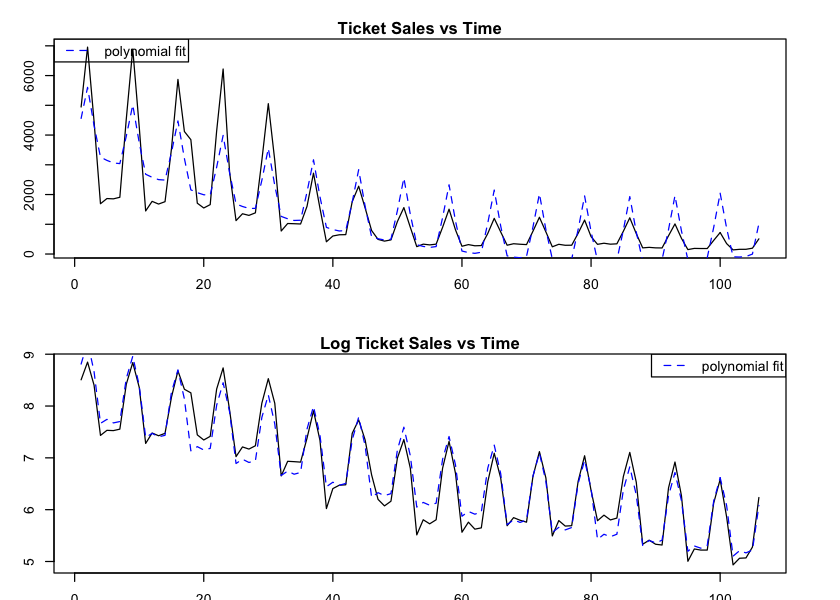

In [34]:
trend = lm(sales ~ time + I(time^2) + days, data = data)
trend2 = lm(LogSales ~ time + I(time^2) + days, data = data)

par(cex=0.7, mai=c(0.1,0.1,0.2,0.1))
par(fig=c(0.05,0.95,0.55,0.975))
plot(data$time, data$sales, type = "l", lty = 1, xlab = "Time", ylab = "Ticket Sales",
main = "Ticket Sales vs Time")
points(time, trend$fitted,type = "l", lty = 2, col = "blue")
legend("topleft", "polynomial fit", lty = 2, col = "blue")
par(fig=c(0.05,0.95,0.025,0.45), new=TRUE)
plot(data$time, data$LogSales, type = "l", lty = 1, xlab = "Time", ylab = "Log Ticket Sales",
main = "Log Ticket Sales vs Time") 
points(time, trend2$fitted,type = "l", lty = 2, col = "blue")
legend("topright", "polynomial fit", lty = 2, col = "blue")


The problem with the first model is that the seasonality factor (day of week) makes up such a large part of fitting the model. The regression underestimates ticket sales during the first 30 days and overestimates the ticket sales during the end. This is because the dummy variables are fixed values. The second regression more accurately traces ticket sales which is needed to obtain the 'rough part'. The rough part is the difference between the blue dashed line and the black line. Essentially the rough part is our error terms and we use these error terms to create a more accurate model. We run time series analysis on the error terms, but these error terms (the rough part) have to follow specific rules.

In [30]:
summary(trend2)


Call:
lm(formula = LogSales ~ time + I(time^2) + days, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5359 -0.1480 -0.0274  0.1490  1.1191 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.8507927  0.0886123  99.882  < 2e-16 ***
time        -0.0409376  0.0030809 -13.288  < 2e-16 ***
I(time^2)    0.0001395  0.0000279   5.002 2.52e-06 ***
daysM       -1.0237228  0.0863777 -11.852  < 2e-16 ***
daysSa       0.4661246  0.0863912   5.396 4.83e-07 ***
daysSu      -0.0596718  0.0863822  -0.691    0.491    
daysTh      -0.8705615  0.0863912 -10.077  < 2e-16 ***
daysTu      -0.9070622  0.0863777 -10.501  < 2e-16 ***
daysW       -0.9361063  0.0863822 -10.837  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2401 on 97 degrees of freedom
Multiple R-squared:  0.9493,	Adjusted R-squared:  0.9451 
F-statistic: 227.1 on 8 and 97 DF,  p-value: < 2.2e-16


This is the regression for our model. The intercept is Friday at time 0. Each subsequent day decreases log sales by (-0.04094)x(n+1) and increases log sales by (0.00014)x(n+1)^2. Friday is not shown as a variable because Friday is calculated into the intercept. This is why the estimate of Sunday is -0.05967. All days of the week are valued by their comparative value to Friday which exceeds all days in sales except Saturday. 

### The Rough Series

Why do we perform time series analysis on the rough series? The rough series is all of the information that our model is unable to take into account. We use the rough series to add an extra layer of accuracy to predictions. It might sound odd but we will be using past error terms to predict future error terms.

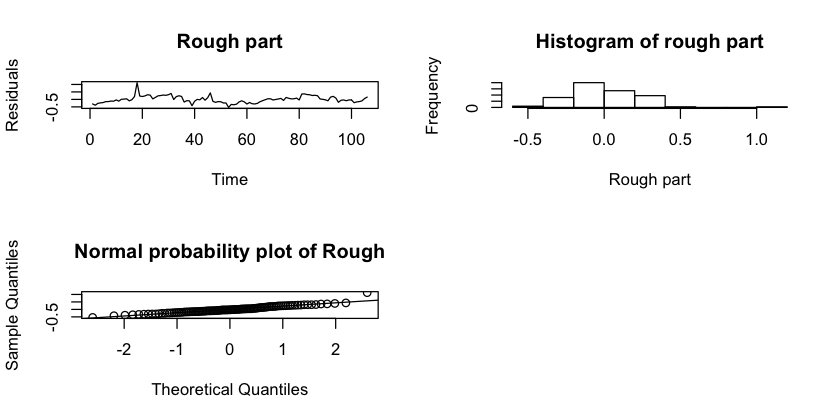

In [38]:
###Analyze the rough part
rough = trend2$residuals

#The histogram of the rough part and the qqnorm
par(mfrow=c(2,2))
plot(rough, type = "l", xlab = "Time", ylab = "Residuals", main = "Rough part")
hist(rough, main = "Histogram of rough part", xlab = "Rough part")
qqnorm(rough, main = "Normal probability plot of Rough")
qqline(rough)

Here we are analyzing the rough part to determine is we can perform time series. The plot on the top left is our rough part. There are certain criteria that we need in order to perform time series analysis on the rough part. For one the rough part graph needs to look random. There cannot be any observed pattern in how errors were made. This assumption would have been violated if we had not transformed the data earlier. Next we must check to see if the error terms are normally distributed. This is shown by the histogram of residuals which resembles a normal distribution. Our qq-plot shows most of the residuals are concentrated within one standard deviation of 0, which increases the normality argument for the residuals.

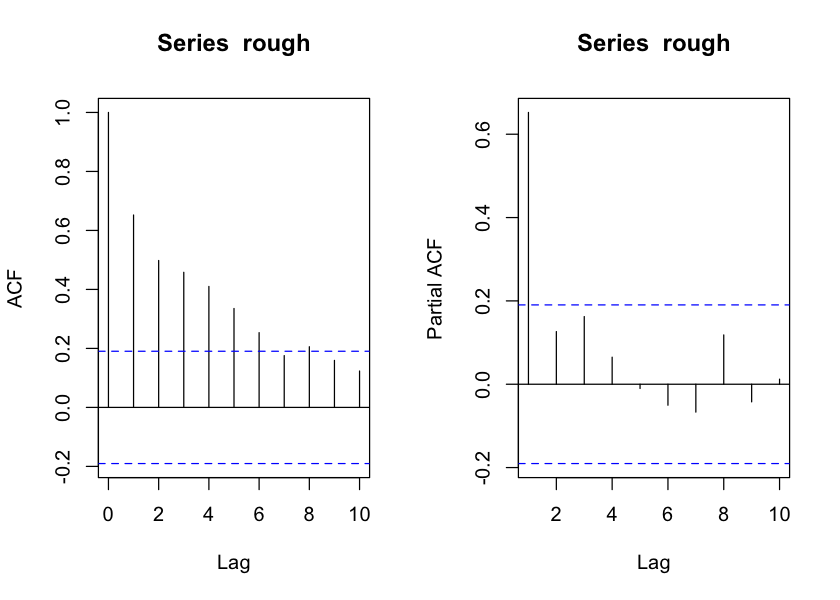

In [32]:
par(mfrow=c(1,2))
acf(rough, lag.max = 10)
pacf(rough, lag.max = 10)

### ARIMA(1,0,1) Model

Next, we will examine the acf and pacf plots. When looking at the pacf plot we see that there is significant partial autocorrelation at lag 1 and then it cuts off. This would indicate that an AR(1) model could be used to predict our rough part. Looking at the acf plot, we see that the autocorrelations are significant up until lag 7, and that the plot seems to tail off. This would indicate that an MA model might not be appropriate.


	Box-Ljung test

data:  model1$residuals
X-squared = 5.2461, df = 10, p-value = 0.8741


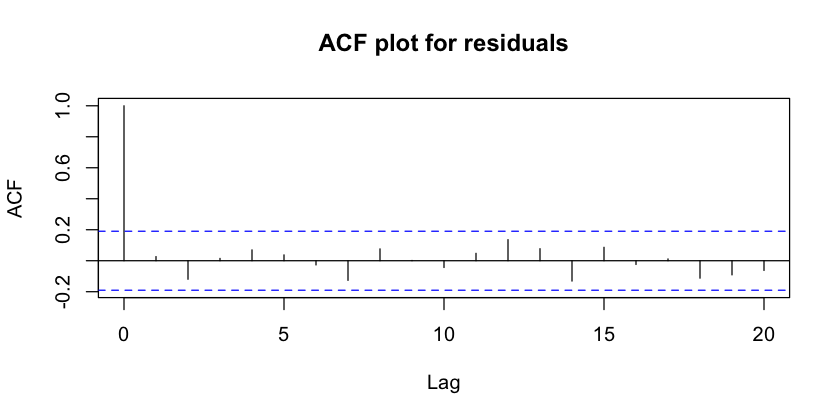

In [37]:
model1 = auto.arima(rough)
acf(model1$residuals,main="ACF plot for residuals")
Box.test(model1$residuals, lag=10, type='Ljung-Box')

An acf plot of the residuals for the model shows that there is no serial correlation which bodes well for the model. Now I use the L-Jung test to check if the residuals are independent which would mean that the model is a good fit. The null hypothesis Ho: is that residuals are indeed independent indicating white noise, and the alternative hypothesis Ha: would mean there is serial correlation and that our model isn’t a good fit. The p-value of our L-Jung test was .8741 which means that we retain the null hypothesis, and furthermore that ARIMA(1, 0, 1) is a good fit.

In [26]:
trend = lm(LogSales ~ time + I(time^2) + days, data = data)
rough = trend$residuals
model = auto.arima(rough, stepwise = FALSE)

In [32]:
auto.arima(x=rough)

Series:  
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.8402  -0.3406
s.e.  0.0819   0.1506

sigma^2 estimated as 0.02934:  log likelihood=37.29
AIC=-68.59   AICc=-68.35   BIC=-60.59

Here I use the auto.arima function to determine the best fit for the time series model. I received an ARIMA(1, 0, 1) model with  ϕ = .8402, and θ = -.3406. MA(1) stands for moverage average. AR(1) stands for autoregression. The model is an AR(1) MA(1) or ARIMA(1,0,1) model. 

My explanation of MA(1) and AR(1) relies on the graph below. In simplistic terms MA(1) is the difference between the black and red line. The difference between the black and red line during period n is multiplied by -0.3406 and then used to predict the the error term of period n+1. AR(1) is just the black line. The black line at period n is multiplied by 0.84 to predict n+1. 

ERROR: Error in lines(model$fitted, col = "red"): object 'model' not found


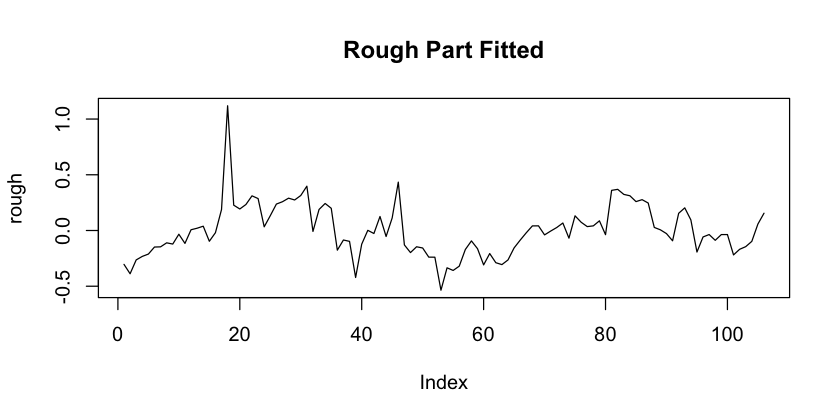

In [36]:
plot(rough, type = 'l', main = "Rough Part Fitted")
lines(model$fitted, col = 'red')
legend("topright", "prediction", lty = 2, col = "red")
legend("bottomright", "actual", lty = 1, col = "black")

Here we examine how well our ARIMA(1,0,1) model is able to predict the error terms. You may notice that our prediction(the red line) is shadowing the actual errors. This is the result of previous error terms being used to determine future error terms. If we had an ARIMA(3,0,2) for example then the prediction would not shadow our model so intensely.

### Examining the Accuracy of Model

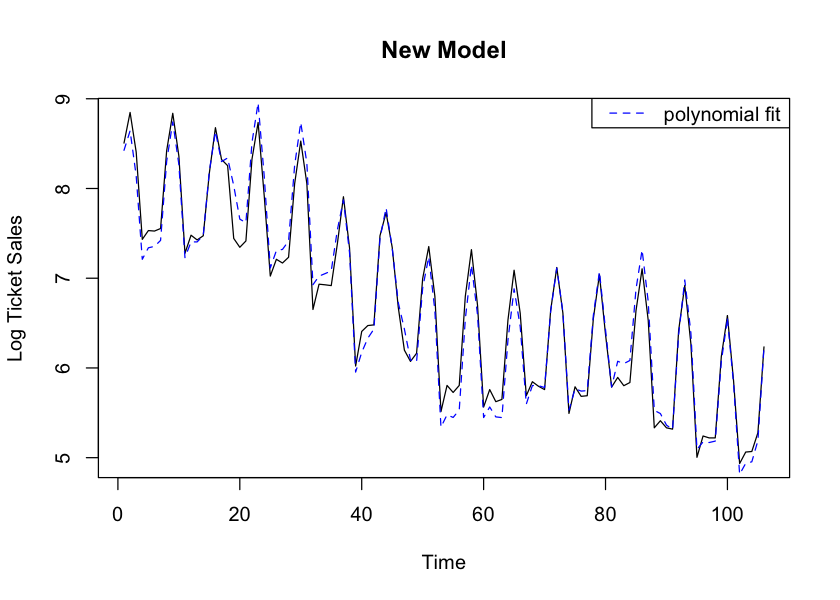

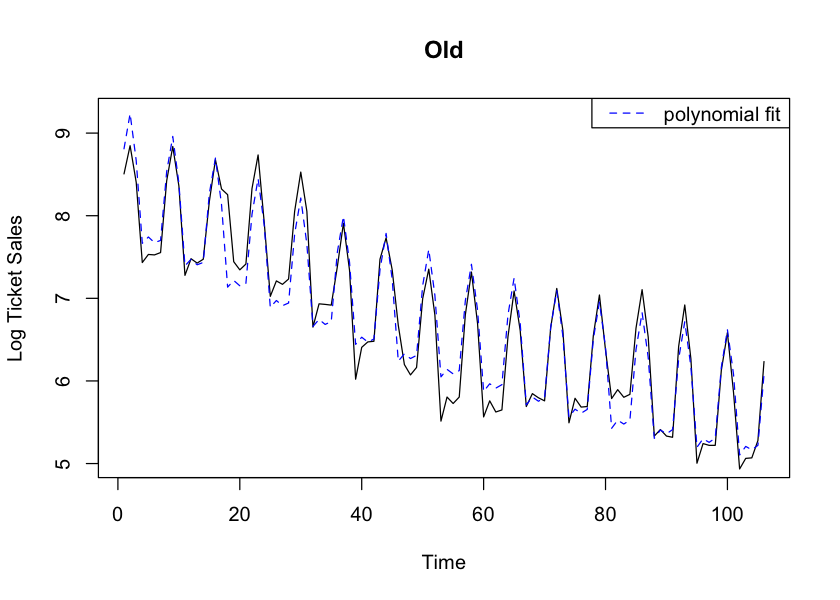

In [77]:
NewPrediction = model2$fitted + data$LogSales

par(mfrow=c(1,1))
plot(data$time, data$LogSales, type = "l", lty = 1, xlab = "Time", ylab = "Log Ticket Sales",
main = "New Model")
points(time, NewPrediction,type = "l", lty = 2, col = "blue")
legend("topright", "polynomial fit", lty = 2, col = "blue")
plot(data$time, data$LogSales, type = "l", lty = 1, xlab = "Time", ylab = "Log Ticket Sales",
main = "Old", ylim = c(5,9.25))
points(time, trend2$fitted,type = "l", lty = 2, col = "blue")
legend("topright", "polynomial fit", lty = 2, col = "blue")

The Old Model represents how well the prediction works when only considering day of week and the time trend. The New Model takes the additional time series analysis into account to produce a tighter fit. This is not actual ticket sales, but the log of ticket sales. For now it is not obvious that adding the additional time series element was very beneficial. 

In [72]:
NewPrediction = model2$fitted + data$LogSales
CorLogOld = cor(data$LogSales, trend2$fitted)
CorLogNew = cor(data$LogSales, NewPrediction)
print(paste('Correlation of fitted log model is',CorLogOld))
print(paste('Correlation of fitted log model with time series is',CorLogNew))

[1] "Correlation of fitted log model is 0.974329202124049"
[1] "Correlation of fitted log model with time series is 0.989173716699604"


When looking at the log of ticket sales between the 2 models there is only a 1.5% difference. 

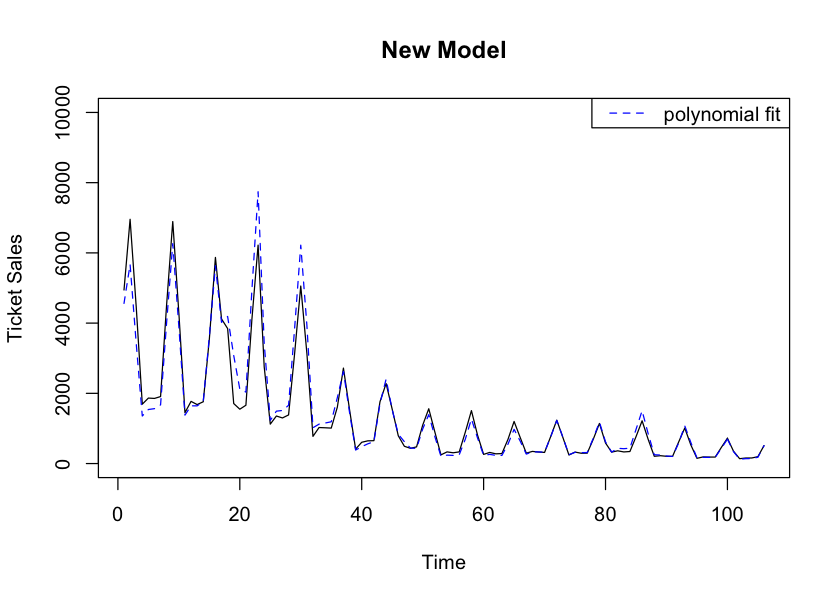

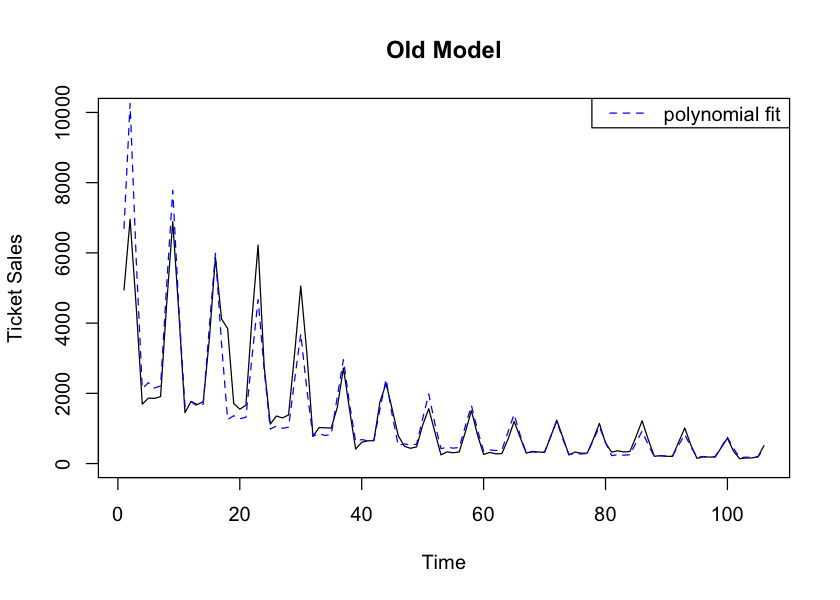

In [88]:
OldPrediction = exp(trend2$fitted)
NewPrediction2 = exp(NewPrediction)

par(mfrow=c(1,1))
plot(time, data$sales, type = "l", lty = 1, xlab = "Time", ylab = "Ticket Sales",
main = "New Model", ylim = c(0,10000))
points(time, NewPrediction2, type = "l", lty = 2, col = "blue")
legend("topright", "polynomial fit", lty = 2, col = "blue")
plot(time, data$sales, type = "l", lty = 1, xlab = "Time", ylab = "Ticket Sales",
main = "Old Model", , ylim = c(0,10000))
points(time, OldPrediction, type = "l", lty = 2, col = "blue")
legend("topright", "polynomial fit", lty = 2, col = "blue")

And finally here we have the actual ticket sales. This is the most important result of our time series analysis. The Old Model routinely underestimates or overestimates actual ticket sales. The New Model only overestimates the fourth and fifth Saturday. After day 30 the New Model very accurately predicts the next 76 days. 

In [75]:
CorLogNew = cor(data$sales, NewPrediction2)
CorLogOld = cor(data$sales, OldPrediction)

print(paste('Correlation of fitted model is',CorLogOld))
print(paste('Correlation of fitted model with time series is',CorLogNew))

[1] "Correlation of fitted log model is 0.943839760186319"
[1] "Correlation of fitted log model with time series is 0.974458074368085"


The correlation of the model has increased by 3 percent when using time series analysis. 

### Conclusion

So why would movie industries be interested in this data? It would be useful to predict future revenue streams so that a movie industry can make a fully informed decision on how they wish to use their assets. Perhaps a movie industry is teetering on a decision to sell off capital to produce revenue, and the company needs an accurate forecast on how their current revenue streams are doing in order to make that decision. Or perhaps a theatre needs to know how many tickets will be sold for purposes of buying beverages, snacks, and for organizing movie layout. Another scenario would be a financial firm looking to invest in the movie studio and needing an accurate description of future sales. 